In [1]:
import scanpy as sc
import pandas as pd
import sys

In [2]:
import echidna as ec
import matplotlib.pyplot as plt
import torch
from scipy.stats import linregress
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from matplotlib.colors import ListedColormap
ec.pl.activate_plot_settings()

In [3]:
def get_binned_DNA_orig(adata, DNA, map, eta):
  barcodes = list(adata.obs_names)
  for i in range(len(barcodes)):
    barcodes[i] = barcodes[i].split("_")[0]
  barcodes_overlap = set(barcodes).intersection(set(DNA.columns))

  DNA = DNA[barcodes]
  DNA = DNA / np.array(DNA).mean(axis=0) * 2 # THIS STEP IS DESCRIBED IN THE PUBLISHED PAPER THIS DATA CAME FROM


  eta_df = pd.DataFrame(eta.cpu().detach().numpy())
  eta_df.columns = adata.var_names

  DNA_clus = pd.DataFrame()
  for cluster in eta_df.index:
    DNA_cluster = []
    obs = adata.obs
    for i in range(len(obs['leiden'].unique())):
        #inds = obs[obs["leiden"]==str(i)].index
        inds = obs[obs["leiden"]==i].index
        inds = [i.split("_")[0] for i in inds]
        DNA_cluster.append(list(DNA[inds].mean(axis=1)))

    DNA_cluster = pd.DataFrame(DNA_cluster)

    gene_names = []
    W1 = []
    for i in range(DNA_cluster.shape[1]):
        genes = str.split(map.iloc[i]["genes"],",")
        gene_names+=genes
        W1+=[DNA_cluster.loc[cluster][i] for j in range(len(genes))]

    DNA_clus[cluster] =  W1
  DNA_clus.index = gene_names
  return DNA_clus, DNA_cluster

In [4]:
# helper function for binning
def binning_eta(df):
    binned = []
    discard_bins = []
    for id, row in map.iterrows():
        genes = str.split(row['genes'],",")
        overlap = list(set(df.columns).intersection(set(genes)))
        in_bin = df[overlap]
        if np.array(in_bin).shape[1] == 0:
            discard_bins.append(id)
            continue
        bin_col = np.array(in_bin).mean(axis=1)
        binned.append(bin_col.reshape(-1, 1))
    binned = np.concatenate(binned, axis=1)
    return binned, discard_bins

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.stats import entropy, ttest_ind
from collections import Counter

def compute_purity(ground_truth, predicted):
    """Compute Purity Score"""
    contingency_matrix = pd.crosstab(ground_truth, predicted)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

def bootstrap_metric(ground_truth, predicted, metric_func, n_bootstrap=100):
    """Compute bootstrapped mean and standard deviation for a given metric."""
    bootstrap_scores = []
    n = len(ground_truth)
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, n, replace=True)
        score = metric_func(ground_truth[indices], predicted[indices])
        bootstrap_scores.append(score)
    return np.mean(bootstrap_scores), np.std(bootstrap_scores)

def evaluate_clustering_metrics(adata, ground_truth_label, labels):
    """Compute clustering metrics for labels in an AnnData object."""
    metrics = {}
    for label in labels:
        ground_truth = adata.obs[ground_truth_label].values
        predicted = adata.obs[label].values

        purity_mean, purity_std = bootstrap_metric(ground_truth, predicted, compute_purity)
        nmi_mean, nmi_std = bootstrap_metric(ground_truth, predicted, normalized_mutual_info_score)
        ami_mean, ami_std = bootstrap_metric(ground_truth, predicted, adjusted_mutual_info_score)
        ari_mean, ari_std = bootstrap_metric(ground_truth, predicted, adjusted_rand_score)

        metrics[label] = {
            'Purity': (purity_mean, purity_std),
            'NMI': (nmi_mean, nmi_std),
            'AMI': (ami_mean, ami_std),
            'ARI': (ari_mean, ari_std)
        }
    return pd.DataFrame(metrics).T

def evaluate_regression_metrics(Xs, Ys, models):
    """Compute regression metrics."""
    metrics = {}
    for i, x, y in enumerate(zip(Xs, Ys)):
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        label = models[i]
        metrics[label] = {'PearsonR': r_value}
    return pd.DataFrame(metrics).T

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Tab10: blue, orange, green, red, purple …
_COLOR_MAP = {
    "echidna":   plt.cm.tab10.colors[0],   # blue
    "inferCNV":  plt.cm.tab10.colors[1],   # orange
    "numbat":    plt.cm.tab10.colors[2],   # green
    "CopyKAT":   plt.cm.tab10.colors[3],   # red
    "XClone":    plt.cm.tab10.colors[4],   # purple
    "XClone_allele": plt.cm.tab10.colors[5],  # brown
}

def _star(p):
    if p < 1e-10:
        return '***'
    if p < 1e-5:
        return '**'
    if p < 0.05:
        return '*'
    return ''

def plot_metric_bar(ax, metric, data, dataset_name, orientation="vertical"):
    """
    Plot a metric for echidna / inferCNV / numbat / CopyKAT / XClone / XClone_allele.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.
    metric : str
        Column name holding (mean, err) tuples.
    data : pd.DataFrame
        Index must contain '<tool>_clones' rows with (mean, err) tuples in `metric`.
    dataset_name : str or list-like
        Still accepted (e.g. for a title), but no longer used to set x‑ticks.
    orientation : "vertical" | "horizontal"
    """
    tools   = ["echidna", "XClone", "XClone_allele", "inferCNV", "CopyKAT", "numbat"]
    rows    = [f"{t}_clones" for t in tools]

    # ------------------------------------------------------------------ #
    # pull values
    # ------------------------------------------------------------------ #
    means, errs = [], []
    for r in rows:
        m, e = data.loc[r, metric] if r in data.index else (0.0, 0.0)
        means.append(m); errs.append(e)

    # sort high → low
    #order  = np.argsort(means)[::-1]
    order = list(range(len(means)))  # no sorting, just keep original order
    means  = [means[i]  for i in order]
    errs   = [errs[i]   for i in order]
    labels = [tools[i]  for i in order]

    n_bars = len(labels)
    x      = np.arange(n_bars)
    width  = 0.6

    if orientation == "horizontal":
        # one bar per method down the y‑axis
        for j in range(n_bars):
            ax.barh(x[j], means[j], height=width,
                    xerr=errs[j], alpha=0.7,
                    color=_COLOR_MAP[labels[j]])

        ax.set_yticks(x)
        ax.set_yticklabels(labels, fontsize=18)          # method names here
        ax.set_xlabel(metric, fontsize=20)
        ax.tick_params(axis="x", labelsize=18)           # larger tick labels
        ax.grid(True, axis="x", linestyle="--", alpha=0.6)

        # significance stars (vs. best bar)
        ref = np.random.normal(means[0], errs[0], 100)
        max_x = max(m + e for m, e in zip(means, errs))
        for j in range(1, n_bars):
            comp  = np.random.normal(means[j], errs[j], 100)
            star  = _star(ttest_ind(ref, comp).pvalue)
            if star:
                y_pos = x[j]
                x_pos = means[j] + errs[j] + 0.02 * max_x
                ax.text(x_pos, y_pos, star, va='center', ha='left', fontsize=12)

        ax.set_xlim(0, max_x + 0.3)

    # ------------------------------------------------------------------ #
    # vertical bars (default)
    # ------------------------------------------------------------------ #
    else:
        for j in range(n_bars):
            ax.bar(x[j], means[j], width,
                   yerr=errs[j], alpha=0.7,
                   color=_COLOR_MAP[labels[j]])

        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=18, rotation=90)  # method names here
        ax.set_ylabel(metric, fontsize=20)
        ax.tick_params(axis="y", labelsize=18)                # bigger y‑tick numbers
        ax.grid(True, axis="y", linestyle="--", alpha=0.6)

        # significance stars (vs. best bar)
        ref   = np.random.normal(means[0], errs[0], 100)
        max_y = max(m + e for m, e in zip(means, errs))
        for j in range(1, n_bars):
            comp = np.random.normal(means[j], errs[j], 100)
            star = _star(ttest_ind(ref, comp).pvalue)
            if star:
                x_pos = x[j]
                y_pos = means[j] + errs[j] + 0.02 * max_y
                ax.text(x_pos, y_pos, star, ha='center', va='bottom', fontsize=12)

        ax.set_ylim(0, max_y + 0.3)

# Tumor 5 clone calling

In [7]:
tumor2 = sc.read_h5ad("data/tumor5/Tumor5_X.h5ad")
tumor2

AnnData object with n_obs × n_vars = 1194 × 29639
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
wdf_tumor2 = pd.read_csv("/home/mingxuanzhang/echidna/data/tumor5/tumor5_processed_w.csv",
                         names=["index", "gene", "counts"],
                         header=0,).set_index("gene").drop("index", axis=1)
wdf_tumor2.head()

,counts
gene,
MIR1302-2HG,0.880625
FAM138A,0.880625
OR4F5,0.880625
AL627309.1,0.880625
AL627309.3,0.880625


In [9]:
def cleaning_ST(adata, wdf):
  matched_genes = adata.var.index.intersection(wdf.index)
  wdf = wdf.loc[matched_genes]
  adata = adata[:, matched_genes]
  wdf = wdf.loc[~wdf.index.duplicated(keep=False)]
  adata = adata[:, wdf.index]
  adata.obs["timepoint"] = "single_tp"
  return adata, wdf

In [10]:
tumor2, wdf_tumor2 = cleaning_ST(tumor2, wdf_tumor2)

/var/tmp/ipykernel_440458/2319707466.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["timepoint"] = "single_tp"


In [11]:
adata = tumor2
num_cells = adata.shape[1]
num_genes = adata.shape[-1]
num_clusters = len(adata.obs['leiden'].unique())
q_corr_init = 0.1
q_shape_rate_scaler = 10.0
eta_mean_init = wdf_tumor2['counts'].mean()
lkj_concentration = 1.0

In [12]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "leiden", # `assert 'leiden' in adata.obs.columns`
    num_cells=num_cells,
    num_genes=num_genes,
    num_clusters=num_clusters,
    inverse_gamma = True, # Inverse Gamma can be more stable in low data settings
    eta_mean_init = eta_mean_init, # Our genes average approximately two copies
    q_corr_init=q_corr_init,
    q_shape_rate_scaler=q_shape_rate_scaler,
    lkj_concentration=lkj_concentration,
    patience = -1, # turn off early stopping
    n_steps = 500, # Passes through the dataset
)

2025-07-23 00:51:38,729 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 119 cells in validation set.
2025-07-23 00:51:38,736 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2025-07-23 00:51:38,744 | INFO : Added `.var[echidna_W_counts]` : CN entries for genes contained in W.
2025-07-23 00:51:38,745 | WARNING : `leiden` changed to `leiden_categorical`.
/home/mingxuanzhang/echidna/echidna/tools/train.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 4 ... 0 3 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  adata.obs.loc[:, config.clusters] = pd.Categorical(adata.obs.loc[:,config.clusters]).codes
training loss: 0.1114 | validation loss: 0.0254: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [01:51<00:00,  4.50it/s]


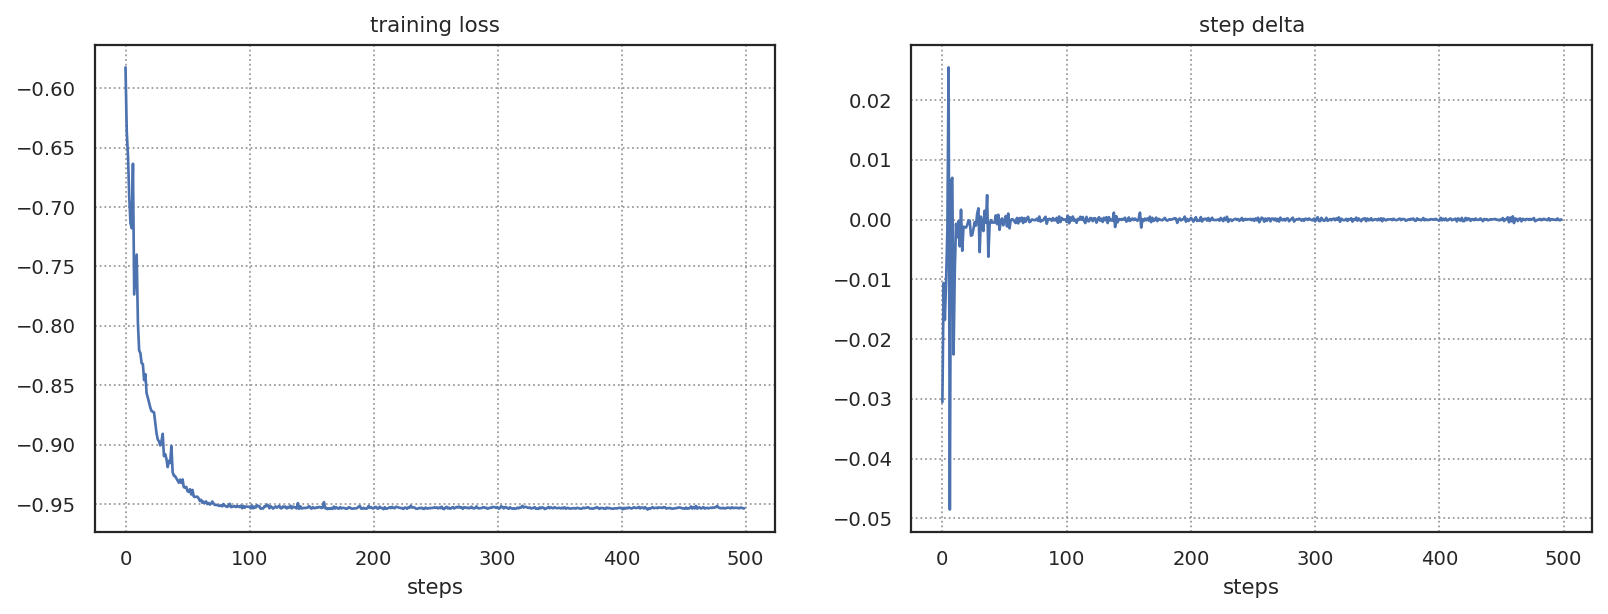

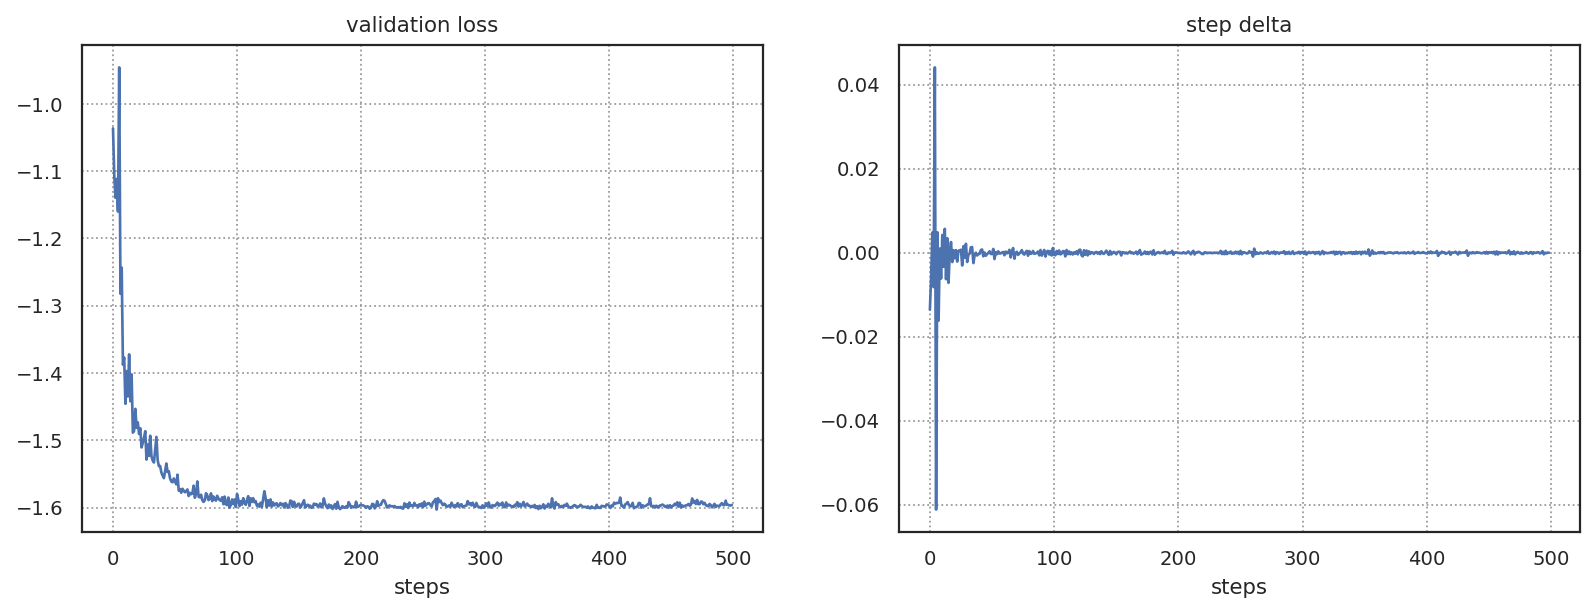

2025-07-23 00:54:03,785 | INFO : Saving echidna model with run_id 20250723-005403.


In [13]:
ec.tl.echidna_train(
     adata # single cell anndata
    , wdf_tumor2.loc[:,"counts"] # Copy number pd.DataFrame, indexed with genes. Select for "on" timepoint.
    , config # config settings
)

In [14]:
ec.tl.echidna_clones(adata, method='manual', metric="smoothed_corr", threshold=0.05)

/home/mingxuanzhang/echidna/echidna/tools/eval.py:375: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in adata.obs[cluster_label]]
2025-07-23 00:54:07,267 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


... storing 'timepoint' as categorical


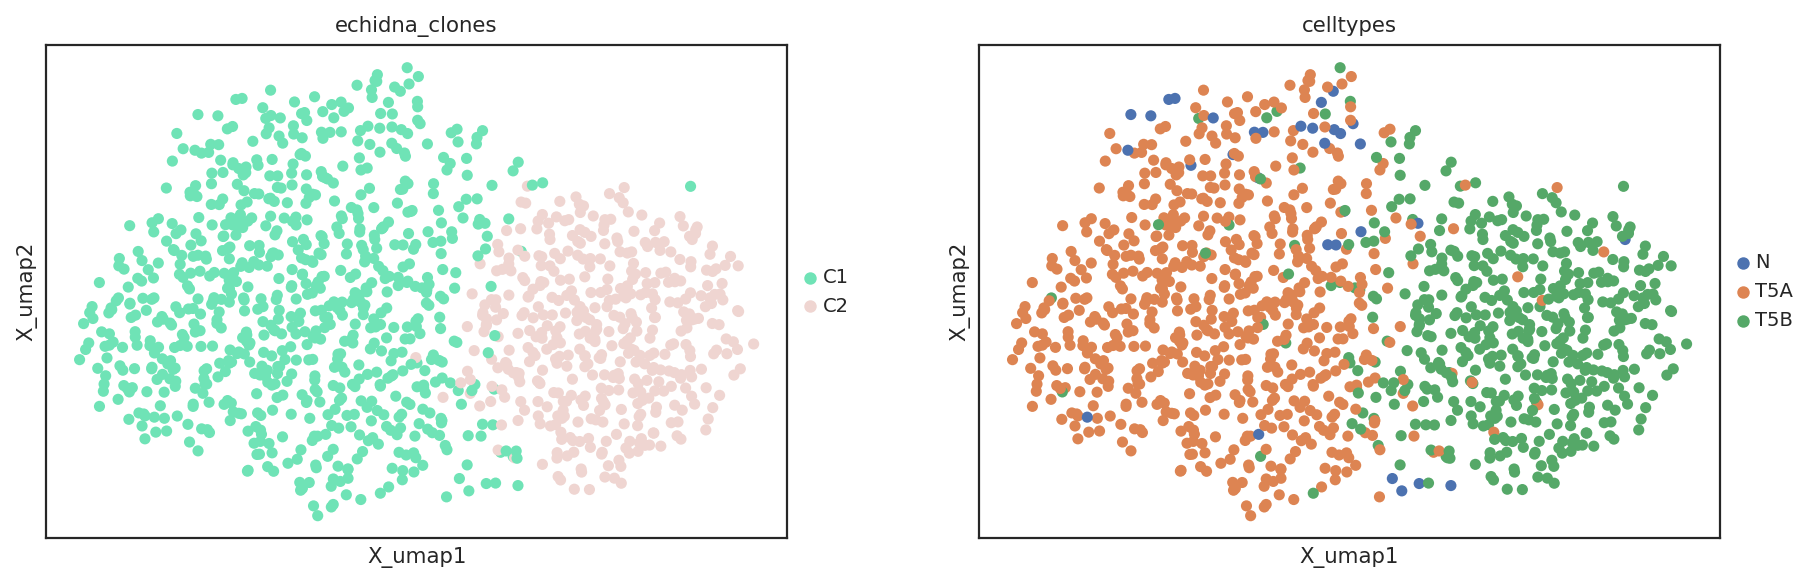

In [15]:
ec.pl.echidna(adata, ["echidna_clones", "celltypes"])

In [16]:
tumor2 = adata.copy()
tumor2.obs['barcode_infercnv'] = [i.split("_")[0] for i in tumor2.obs_names]
tumor2.obs['barcode_numbat'] = [i.split("_")[0][:-1] for i in tumor2.obs_names]
tumor2.obs['barcode_orig'] = tumor2.obs_names
tumor2

AnnData object with n_obs × n_vars = 1194 × 18675
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden', 'timepoint', 'echidna_split', 'leiden_categorical', 'echidna_clones', 'barcode_infercnv', 'barcode_numbat', 'barcode_orig'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'echidna_matched_genes', 'echidna_W_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'echidna', 'echidna_clones_colors', 'celltypes_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [17]:
ec_model = ec.tl.load_model(tumor2,
                            save_folder="/home/mingxuanzhang/echidna/model_tumor5",
                            model_config=config)
eta_tumor2 = ec_model.eta_posterior

In [18]:
len(tumor2.obs['leiden'].unique())

5

In [19]:
DNA_tumor2 =  pd.read_csv("/home/mingxuanzhang/echidna/data/tumor5/DNA_bin_counts_matrix.txt", sep='\t')
map = pd.read_csv("/home/mingxuanzhang/echidna/data/bin-boundaries and genes.txt",sep='\t')
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_binned, discard_bins = binning_eta(eta_df_tumor2)
_, DNA_cluster = get_binned_DNA_orig(tumor2, DNA_tumor2, map, eta_tumor2)
valid_bins = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster = DNA_cluster[valid_bins]

In [20]:
DNA_cluster

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,1.615282,4.312475,1.625481,2.435486,2.985087,3.232496,2.402020,2.570154,2.416687,2.847828,...,1.295658,1.929981,2.880559,1.355060,1.080895,1.368031,1.659186,2.777073,1.590079,2.293189
1,1.558485,1.801432,1.565761,2.462949,2.738681,2.243159,2.629336,2.498332,2.016767,2.332534,...,1.678877,2.047064,2.815193,1.459782,1.061294,1.262223,1.875649,2.696005,1.428989,2.101816
2,1.522017,2.114805,1.461696,2.406519,2.896999,2.462845,2.571283,2.372398,2.374101,2.358601,...,1.519061,2.073305,2.621790,1.785219,1.022788,1.221225,1.455019,2.651880,1.410461,2.098597
3,1.577837,2.087521,1.465976,2.141261,2.915506,2.398736,2.560699,2.319713,2.169249,2.309782,...,1.527827,2.060394,2.783581,1.618708,0.989976,1.288968,1.537481,2.694135,1.403821,2.040891
4,1.781767,2.125956,1.595032,2.648626,2.627877,2.416778,2.514020,2.583608,2.183807,2.459525,...,1.444348,1.838049,2.761060,1.601469,1.157054,1.455361,1.702019,2.882025,1.552469,2.187838


In [21]:
#np.save("/home/mingxuanzhang/echidna/benchmarking_data/echidna_binned_tumor5.npy", eta_binned)

In [22]:
#np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_echidna_tumor5.npy", DNA_cluster.values)

## InferCNV

In [23]:
infercnv = pd.read_csv('/home/mingxuanzhang/echidna/benchmarking_data/infercnv_tumor5', index_col=0)
infercnv.head()

,AAACATAAAATGTCTGT1,AAACATAATTTCCGTTC1,AAACATACCTGCAATAT1,AAACATAGAACCTCATC1,AAACATAGCGTTTGATA1,AAACATAGTCACGTTAG1,AAACATATCCGGTCTAC1,AAACATATTTACCGTCT1,AAACATGAGGTATAAGC1,AAACATGATAGAACTAG1,...,TTTTATTAAGCTCGACA1,TTTTATTAAGCTGGTAT1,TTTTATTACCGTCAATA1,TTTTATTAGGAATAAGC1,TTTTATTATTCTAATTG1,TTTTATTATTCTACAAT1,TTTTATTATTCTAGTGT1,TTTTATTATTCTATTAA1,TTTTATTCTTCATGTGG1,TTTTATTGGTGCCAATA1
chr1.WASH7P,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,...,1.00033,1.00033,1.00033,1.00033,1.00033,1.044784,1.00033,1.00033,1.00033,1.00033
chr1.OR4F5,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,...,1.00033,1.00033,1.00033,1.00033,1.00033,1.044506,1.00033,1.00033,1.00033,1.00033
chr1.LOC100133331,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,...,1.00033,1.00033,1.00033,1.00033,1.00033,1.044244,1.00033,1.00033,1.00033,1.00033
chr1.LOC100288069,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,...,1.00033,1.00033,1.00033,1.00033,1.00033,1.044020,1.00033,1.00033,1.00033,1.00033
chr1.LINC00115,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,1.00033,...,1.00033,1.00033,1.00033,1.00033,1.00033,1.043839,1.00033,1.00033,1.00033,1.00033


In [24]:
infercnv.index = infercnv.index.str.split('.').str[-1]
infercnv = infercnv.T
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(infercnv.index)
columns = tumor2.var.index.intersection(infercnv.T.index)
X_ = tumor2[rows, columns]
infercnv = infercnv.loc[rows, columns]
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, infercnv.shape, eta_df_tumor2.shape)

(1194, 13063) (1194, 13063) (5, 13063)


In [25]:
X_.X = infercnv
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [26]:
infercnv_binned, discard_bins = binning_eta(cnv_df)
valid_bins_infercnv = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_infercnv = DNA_cluster[valid_bins_infercnv]

In [27]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(infercnv_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [28]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['inferCNV_clones'] = leiden_clusters.map(leiden_to_kmeans)

## Numbat

In [29]:
numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor5/bulk_clones_final.tsv.gz", sep='\t', compression='gzip')
numbat_bulk = numbat_bulk[numbat_bulk['LLR'] >= 10]
#numbat_bulk = numbat_bulk.dropna() # COMMENT OUT FOR TUMOR 5, FOR TUMOR 2 RUN THIS LINE
numbat_bulk = numbat_bulk[numbat_bulk['n_cells'] > 50]

/var/tmp/ipykernel_440458/1170749291.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor5/bulk_clones_final.tsv.gz", sep='\t', compression='gzip')


In [30]:
gene_cnv = (numbat_bulk
            .groupby(['sample', 'gene'], as_index=False)
            .agg(median_phi_mle=('phi_mle', 'median')))
gene_cnv['est_cn'] = gene_cnv['median_phi_mle']
clone_by_gene = gene_cnv.pivot(index='sample', columns='gene', values='est_cn')
clone_by_gene.fillna(1.0, inplace=True) # neutral is 1.0
clone_by_gene.loc[1] = [1.0] * len(clone_by_gene.columns)
clone_by_gene.index.names = ['clone_opt'] # clone 1 is assigned as normal cells

In [31]:
numbat_clones = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor5/clone_post_2.tsv", sep='\t')
numbat_clones.index = numbat_clones['cell']
tumor2.obs_names = tumor2.obs['barcode_numbat']
overlapping_barcodes = set(list(tumor2.obs_names)).intersection(set(list(numbat_clones.index)))
tumor2 = tumor2[tumor2.obs_names.isin(overlapping_barcodes)]
numbat_clones = numbat_clones.loc[list(overlapping_barcodes)]
numbat_clones = numbat_clones.reindex(tumor2.obs_names)
tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)

/var/tmp/ipykernel_440458/1377149612.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)


## Copykat

In [32]:
copykat = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/copykat_tumor5/t5_r1_copykat_CNA_raw_results_gene_by_cell.txt", sep='\t')
copykat = copykat.set_index('hgnc_symbol')
copykat.head()

,abspos,chromosome_name,start_position,end_position,ensembl_gene_id,band,AAACATAAAATGTCTGT1,AAACATAATTTCCGTTC1,AAACATAGAACCTCATC1,AAACATAGCGTTTGATA1,...,TTTTATGGACGTTGTAA1,TTTTATGGGTTTAGACT1,TTTTATTAAGCTCGACA1,TTTTATTAAGCTGGTAT1,TTTTATTACCGTCAATA1,TTTTATTAGGAATAAGC1,TTTTATTATTCTAATTG1,TTTTATTATTCTAGTGT1,TTTTATTATTCTATTAA1,TTTTATTCTTCATGTGG1
hgnc_symbol,,,,,,,,,,,,,,,,,,,,,
WASH7P,21987,1,14404,29570,ENSG00000227232,p36.33,0.020612,0.071762,-0.022802,-0.065311,...,0.032706,0.029622,-0.044019,-0.031497,-0.046636,-0.041693,-0.000631,-0.06048,-0.008237,-0.049354
KLHL17,963151,1,960587,965715,ENSG00000187961,p36.33,0.020612,0.071762,-0.022802,-0.065311,...,0.032706,0.029622,-0.044019,-0.031497,-0.046636,-0.041693,-0.000631,-0.06048,-0.008237,-0.049354
AGRN,1038120,1,1020123,1056118,ENSG00000188157,p36.33,0.020612,0.071762,-0.022802,-0.065311,...,0.032706,0.029622,-0.044019,-0.031497,-0.046636,-0.041693,-0.000631,-0.06048,-0.008237,-0.049354
ACAP3,1300992,1,1292376,1309609,ENSG00000131584,p36.33,0.020612,0.071762,-0.022802,-0.065311,...,0.032706,0.029622,-0.044019,-0.031497,-0.046636,-0.041693,-0.000631,-0.06048,-0.008237,-0.049354
INTS11,1318138,1,1311585,1324691,ENSG00000127054,p36.33,0.020612,0.071762,-0.022802,-0.065311,...,0.032706,0.029622,-0.044019,-0.031497,-0.046636,-0.041693,-0.000631,-0.06048,-0.008237,-0.049354


In [33]:
copykat.shape

(2206, 1643)

In [34]:
copykat = copykat.T
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(copykat.index)
columns = tumor2.var.index.intersection(copykat.T.index)
print(len(rows), len(columns))
X_ = tumor2[rows, columns]
copykat = copykat.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, copykat.shape, eta_df_tumor2.shape)

1131 1722
(1131, 1722) (1131, 1722) (5, 1722)


In [36]:
X_.X = copykat
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [37]:
copykat_binned, discard_bins = binning_eta(cnv_df)
valid_bins_copykat = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_copykat = DNA_cluster[valid_bins_copykat]

In [38]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(copykat_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [39]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['CopyKAT_clones'] = leiden_clusters.map(leiden_to_kmeans)

In [40]:
tumor2.obs['ground_truth_clones'] = tumor2.obs['celltypes']

## XClone

In [41]:
xclone = sc.read_h5ad("/home/mingxuanzhang/echidna/benchmarking_data/xclone_tumor5/data/RDR_adata_KNN_HMM_post.h5ad")
xclone

AnnData object with n_obs × n_vars = 1902 × 2444
    obs: 'Type', 'cell_type', 'obs_names', 'counts_ratio'
    var: 'GeneName', 'arm', 'band', 'chr', 'chr_arm', 'gieStain', 'start', 'stop', 'var_names', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped'
    uns: 'CNV_ratio', 'Logliklihood', 'chr_dict', 'dispersion_base_celltype', 'fit_dispersion_removed_genes', 'group_genes', 'guide_CNV_chrs_use_anno_key', 'guide_CNV_chrs_use_layers', 'neighbors', 'pca', 'rank_marker_genes', 'ref_log_expression_brk'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'RDR_smooth', 'posterior_mtx', 'posterior_mtx_log', 'raw_expr'
    obsp: 'connectivities', 'distances'

In [42]:
xclone.var['genes'] = [g.split(".")[-1] for g in list(xclone.var['GeneName'])]
xclone.var['genes']

5           ABL2
7          ACAP3
13          ACP6
21       ADAMTS4
23          ADAR
          ...   
21493       WWC3
21519      ZMYM3
21531      ZNF81
21532      ZRSR2
21545       CD99
Name: genes, Length: 2444, dtype: object

In [43]:
from sklearn.preprocessing import StandardScaler
state_score = np.array([-1, 0, 1], dtype=float)
post = xclone.layers['posterior_mtx'].copy()
scores = np.tensordot(post, state_score, axes=(-1, 0))
#H = -(post * np.log(post + 1e-12)).sum(-1)
#input_mat = np.hstack([scores, H])
input_mat = scores
input_mat = StandardScaler().fit_transform(input_mat)
input_mat.shape

(1902, 2444)

In [44]:
xclone = pd.DataFrame(input_mat, index=xclone.obs['obs_names'], columns=xclone.var['genes'])
xclone

genes,ABL2,ACAP3,ACP6,ADAMTS4,ADAR,ADGRL2,AGO1,AGO3,AGRN,AHCYL1,...,UBA1,USP11,USP9X,VSIG4,WDR13,WWC3,ZMYM3,ZNF81,ZRSR2,CD99
obs_names,,,,,,,,,,,,,,,,,,,,,
AAACATAAAATGTCTGT1,-0.250081,-0.250081,-0.250080,-0.250079,-0.250077,-0.250075,-0.250073,-0.250071,-0.250068,-0.250066,...,2.535052,2.535052,2.535053,2.535055,2.535058,2.535060,2.535061,2.535062,2.535063,3.543067
AAACATAATTTCCGTTC1,-1.336188,-1.336187,-1.336187,-1.336186,-1.336185,-1.336184,-1.336184,-1.336184,-1.336185,-1.336185,...,2.576772,2.576774,2.576776,2.576776,2.576778,2.576779,2.576781,2.576782,2.576782,-0.285208
AAACATACCTGCAATAT1,-0.383767,-0.383766,-0.383767,-0.383766,-0.383766,-0.383766,-0.383765,-0.383764,-0.383763,-0.383762,...,-1.281754,-1.281755,-1.281757,-1.281758,-1.281759,-1.281760,-1.281761,-1.281762,-1.281762,-0.538348
AAACATAGAACCTCATC1,0.207802,0.207802,0.207801,0.207801,0.207799,0.207798,0.207795,0.207793,0.207792,0.207790,...,-0.846398,-0.846398,-0.846399,-0.846399,-0.846399,-0.846399,-0.846400,-0.846400,-0.846400,-0.604646
AAACATAGCGTTTGATA1,0.305342,0.305343,0.305343,0.305343,0.305344,0.305345,0.305346,0.305347,0.305348,0.305349,...,0.191506,0.191505,0.191503,0.191501,0.191499,0.191497,0.191497,0.191496,0.191496,-0.679936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTATTATTCTACAAT1,-0.720949,-0.720949,-0.720949,-0.720949,-0.720949,-0.720948,-0.720948,-0.720948,-0.720948,-0.720948,...,0.247251,0.247249,0.247247,0.247246,0.247245,0.247244,0.247243,0.247243,0.247243,0.420279
TTTTATTATTCTAGTGT1,-0.214298,-0.214299,-0.214299,-0.214299,-0.214299,-0.214300,-0.214300,-0.214300,-0.214301,-0.214302,...,-0.183928,-0.183931,-0.183933,-0.183934,-0.183935,-0.183936,-0.183936,-0.183937,-0.183937,0.326574
TTTTATTATTCTATTAA1,1.370727,1.370727,1.370727,1.370727,1.370727,1.370727,1.370727,1.370727,1.370726,1.370725,...,-0.818443,-0.818442,-0.818441,-0.818440,-0.818439,-0.818439,-0.818439,-0.818438,-0.818439,-0.577232


In [45]:
xclone.T

obs_names,AAACATAAAATGTCTGT1,AAACATAATTTCCGTTC1,AAACATACCTGCAATAT1,AAACATAGAACCTCATC1,AAACATAGCGTTTGATA1,AAACATAGTCACGTTAG1,AAACATATCCGGTCTAC1,AAACATATTTACCGTCT1,AAACATGAGGTATAAGC1,AAACATGATAGAACTAG1,...,TTTTATTAAGCTCGACA1,TTTTATTAAGCTGGTAT1,TTTTATTACCGTCAATA1,TTTTATTAGGAATAAGC1,TTTTATTATTCTAATTG1,TTTTATTATTCTACAAT1,TTTTATTATTCTAGTGT1,TTTTATTATTCTATTAA1,TTTTATTCTTCATGTGG1,TTTTATTGGTGCCAATA1
genes,,,,,,,,,,,,,,,,,,,,,
ABL2,-0.250081,-1.336188,-0.383767,0.207802,0.305342,0.193326,0.231538,-0.895155,2.048356,2.252685,...,3.004809,-0.328099,-0.102125,-0.031841,-0.703331,-0.720949,-0.214298,1.370727,-0.898895,-0.989790
ACAP3,-0.250081,-1.336187,-0.383766,0.207802,0.305343,0.193327,0.231538,-0.895154,2.048357,2.252685,...,3.004809,-0.328099,-0.102125,-0.031841,-0.703331,-0.720949,-0.214299,1.370727,-0.898894,-0.989791
ACP6,-0.250080,-1.336187,-0.383767,0.207801,0.305343,0.193327,0.231539,-0.895154,2.048356,2.252685,...,3.004808,-0.328099,-0.102124,-0.031841,-0.703330,-0.720949,-0.214299,1.370727,-0.898894,-0.989791
ADAMTS4,-0.250079,-1.336186,-0.383766,0.207801,0.305343,0.193326,0.231539,-0.895154,2.048355,2.252686,...,3.004807,-0.328099,-0.102123,-0.031840,-0.703330,-0.720949,-0.214299,1.370727,-0.898893,-0.989792
ADAR,-0.250077,-1.336185,-0.383766,0.207799,0.305344,0.193326,0.231540,-0.895153,2.048354,2.252687,...,3.004808,-0.328099,-0.102122,-0.031840,-0.703329,-0.720949,-0.214299,1.370727,-0.898892,-0.989792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WWC3,2.535060,2.576779,-1.281760,-0.846399,0.191497,0.206243,0.133355,-1.718991,0.136975,0.931947,...,-0.550126,-0.247773,-0.524536,-1.157331,1.071279,0.247244,-0.183936,-0.818439,1.628013,0.502807
ZMYM3,2.535061,2.576781,-1.281761,-0.846400,0.191497,0.206242,0.133353,-1.718991,0.136975,0.931948,...,-0.550127,-0.247772,-0.524536,-1.157331,1.071279,0.247243,-0.183936,-0.818439,1.628013,0.502808
ZNF81,2.535062,2.576782,-1.281762,-0.846400,0.191496,0.206243,0.133351,-1.718991,0.136975,0.931949,...,-0.550127,-0.247771,-0.524535,-1.157332,1.071278,0.247243,-0.183937,-0.818438,1.628013,0.502809


In [46]:
tumor2.obs_names = tumor2.obs['barcode_infercnv']
rows = tumor2.obs.index.intersection(xclone.index)
print(xclone.index)
columns = tumor2.var.index.intersection(xclone.T.index)
X_ = tumor2[rows, columns]
xclone = xclone.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, xclone.shape, eta_df_tumor2.shape)

Index(['AAACATAAAATGTCTGT1', 'AAACATAATTTCCGTTC1', 'AAACATACCTGCAATAT1',
       'AAACATAGAACCTCATC1', 'AAACATAGCGTTTGATA1', 'AAACATAGTCACGTTAG1',
       'AAACATATCCGGTCTAC1', 'AAACATATTTACCGTCT1', 'AAACATGAGGTATAAGC1',
       'AAACATGATAGAACTAG1',
       ...
       'TTTTATTAAGCTCGACA1', 'TTTTATTAAGCTGGTAT1', 'TTTTATTACCGTCAATA1',
       'TTTTATTAGGAATAAGC1', 'TTTTATTATTCTAATTG1', 'TTTTATTATTCTACAAT1',
       'TTTTATTATTCTAGTGT1', 'TTTTATTATTCTATTAA1', 'TTTTATTCTTCATGTGG1',
       'TTTTATTGGTGCCAATA1'],
      dtype='object', name='obs_names', length=1902)
(1193, 1876) (1193, 1876) (5, 1876)


In [47]:
X_.X = xclone
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [48]:
xclone_binned, discard_bins = binning_eta(cnv_df)
valid_bins_xclone = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_xclone = DNA_cluster[valid_bins_xclone]

In [49]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(xclone_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [50]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['XClone_clones'] = leiden_clusters.map(leiden_to_kmeans)

# XClone with allele

In [51]:
xclone = sc.read_h5ad("/home/mingxuanzhang/echidna/benchmarking_data/xclone_tumor5/data/xclone_tumor5_outputs_combine5_data_combined_final.h5ad")
xclone

AnnData object with n_obs × n_vars = 1902 × 6325
    obs: 'matched_name', 'Type', 'cell_type', 'counts_ratio'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped', 'gene_index'
    uns: 'CNV_ratio', 'Logliklihood', 'chr_dict', 'data_mode', 'data_notes', 'dispersion_base_celltype', 'fit_dispersion_removed_genes', 'genome_mode', 'group_genes', 'guide_CNV_chrs_use_anno_key', 'guide_CNV_chrs_use_layers', 'log', 'neighbors', 'pca', 'rank_marker_genes', 'ref_log_expression_brk'
    obsm: 'WGD_prop', 'X_pca'
    varm: 'PCs'
    layers: 'BAF_extend_post_prob', 'RDR_smooth', 'WGD_bool', 'combine_base_prob', 'corrected_prob', 'plot_prob_merge1', 'plot_prob_merge2', 'plot_prob_merge3', 'plot_prob_merge4', 'posterior_mtx', 'posterior_mtx_log', 'prob1_merge', 'raw_expr', 'rdr_posterior_mtx_denoised'
    obsp: 'connectivities', 'distances'

In [52]:
xclone.var['genes'] = [g.split(".")[-1] for g in list(xclone.var['GeneName'])]
xclone.var['genes']

9                10
10           OR4F29
16                4
18           OR4F16
19                3
            ...    
32642    NLGN4Y-AS1
32650         HSFY1
32657        TTTY10
32661       CYorf17
32672        RBMY1J
Name: genes, Length: 6325, dtype: object

In [53]:
xclone.layers['prob1_merge'].shape

(1902, 6325, 4)

In [54]:
from sklearn.preprocessing import StandardScaler
state_score = np.array([-1, 0, 1], dtype=float)
post = xclone.layers['posterior_mtx'].copy()
scores = np.tensordot(post, state_score, axes=(-1, 0))
#H = -(post * np.log(post + 1e-12)).sum(-1)
#input_mat = np.hstack([scores, H])
input_mat = scores
input_mat = StandardScaler().fit_transform(input_mat)
input_mat.shape

(1902, 6325)

In [55]:
xclone = pd.DataFrame(input_mat, index=xclone.obs['matched_name'], columns=xclone.var['genes'])
xclone

genes,10,OR4F29,4,OR4F16,3,1,2,SAMD11,1,AGRN,...,TTTY2,TTTY23,USP9Y,UTY,VCY,NLGN4Y-AS1,HSFY1,TTTY10,CYorf17,RBMY1J
matched_name,,,,,,,,,,,,,,,,,,,,,
AAACATAAAATGTCTGT,0.268064,0.268064,0.268064,0.268063,0.268061,0.268059,0.268057,0.268055,0.268053,0.268051,...,0.136177,0.136177,0.361511,0.361512,0.361513,0.361513,0.361513,0.361514,0.361515,0.361515
AAACATAATTTCCGTTC,0.126190,0.126190,0.126191,0.126193,0.126195,0.126197,0.126199,0.126202,0.126205,0.126208,...,1.809899,1.809902,-0.614819,-0.614824,-0.614830,-0.614835,-0.614839,-0.614841,-0.614842,-0.614842
AAACATACCTGCAATAT,0.931622,0.931622,0.931623,0.931623,0.931622,0.931622,0.931622,0.931622,0.931623,0.931623,...,-1.102268,-1.102265,-1.590804,-1.590804,-1.590804,-1.590805,-1.590805,-1.590805,-1.590806,-1.590807
AAACATAGAACCTCATC,0.121066,0.121065,0.121065,0.121064,0.121063,0.121062,0.121061,0.121060,0.121060,0.121060,...,-0.726583,-0.726582,2.151437,2.151440,2.151441,2.151443,2.151446,2.151453,2.151457,2.151460
AAACATAGCGTTTGATA,-0.122957,-0.122957,-0.122956,-0.122956,-0.122955,-0.122954,-0.122953,-0.122953,-0.122953,-0.122952,...,1.123505,1.123511,-0.483440,-0.483442,-0.483443,-0.483443,-0.483444,-0.483444,-0.483442,-0.483443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTATTATTCTACAAT,-0.079623,-0.079622,-0.079623,-0.079623,-0.079623,-0.079623,-0.079623,-0.079622,-0.079623,-0.079625,...,-1.155444,-1.155444,-0.017064,-0.017063,-0.017061,-0.017059,-0.017056,-0.017054,-0.017051,-0.017052
TTTTATTATTCTAGTGT,0.130795,0.130796,0.130796,0.130797,0.130798,0.130799,0.130799,0.130800,0.130800,0.130800,...,-0.086111,-0.086110,-0.503064,-0.503064,-0.503064,-0.503065,-0.503067,-0.503070,-0.503072,-0.503072
TTTTATTATTCTATTAA,0.131341,0.131341,0.131341,0.131342,0.131342,0.131342,0.131343,0.131343,0.131344,0.131345,...,-1.529191,-1.529191,-1.322631,-1.322630,-1.322631,-1.322631,-1.322631,-1.322631,-1.322632,-1.322632


In [56]:
xclone.T

matched_name,AAACATAAAATGTCTGT,AAACATAATTTCCGTTC,AAACATACCTGCAATAT,AAACATAGAACCTCATC,AAACATAGCGTTTGATA,AAACATAGTCACGTTAG,AAACATATCCGGTCTAC,AAACATATTTACCGTCT,AAACATGAGGTATAAGC,AAACATGATAGAACTAG,...,TTTTATTAAGCTCGACA,TTTTATTAAGCTGGTAT,TTTTATTACCGTCAATA,TTTTATTAGGAATAAGC,TTTTATTATTCTAATTG,TTTTATTATTCTACAAT,TTTTATTATTCTAGTGT,TTTTATTATTCTATTAA,TTTTATTCTTCATGTGG,TTTTATTGGTGCCAATA
genes,,,,,,,,,,,,,,,,,,,,,
10,0.268064,0.126190,0.931622,0.121066,-0.122957,0.120283,0.126083,-0.015319,0.132498,0.129841,...,0.131553,0.254325,0.133085,-0.704224,0.122946,-0.079623,0.130795,0.131341,0.140425,0.110171
OR4F29,0.268064,0.126190,0.931622,0.121065,-0.122957,0.120283,0.126084,-0.015318,0.132498,0.129840,...,0.131552,0.254324,0.133085,-0.704224,0.122946,-0.079622,0.130796,0.131341,0.140425,0.110171
4,0.268064,0.126191,0.931623,0.121065,-0.122956,0.120283,0.126083,-0.015319,0.132499,0.129841,...,0.131552,0.254324,0.133085,-0.704225,0.122946,-0.079623,0.130796,0.131341,0.140424,0.110172
OR4F16,0.268063,0.126193,0.931623,0.121064,-0.122956,0.120284,0.126082,-0.015319,0.132499,0.129841,...,0.131552,0.254323,0.133086,-0.704226,0.122946,-0.079623,0.130797,0.131342,0.140423,0.110171
3,0.268061,0.126195,0.931622,0.121063,-0.122955,0.120284,0.126082,-0.015319,0.132499,0.129841,...,0.131553,0.254322,0.133087,-0.704228,0.122946,-0.079623,0.130798,0.131342,0.140422,0.110170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NLGN4Y-AS1,0.361513,-0.614835,-1.590805,2.151443,-0.483443,-1.101373,-1.740329,-0.469744,-1.836075,-0.276318,...,-0.260727,-0.948427,0.542426,1.747362,0.995282,-0.017059,-0.503065,-1.322631,-0.907873,0.095060
HSFY1,0.361513,-0.614839,-1.590805,2.151446,-0.483444,-1.101369,-1.740330,-0.469747,-1.836074,-0.276316,...,-0.260720,-0.948430,0.542431,1.747367,0.995284,-0.017056,-0.503067,-1.322631,-0.907876,0.095065
TTTY10,0.361514,-0.614841,-1.590805,2.151453,-0.483444,-1.101368,-1.740330,-0.469752,-1.836075,-0.276315,...,-0.260712,-0.948433,0.542436,1.747372,0.995289,-0.017054,-0.503070,-1.322631,-0.907877,0.095071


In [57]:
tumor2.obs_names = tumor2.obs['barcode_numbat']
rows = tumor2.obs.index.intersection(xclone.index)
print(xclone.index)
columns = tumor2.var.index.intersection(xclone.T.index)
xclone  = xclone.loc[:, ~xclone.columns.duplicated()]
X_ = tumor2[rows, columns]
xclone = xclone.loc[rows, columns]
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_df_tumor2 = eta_df_tumor2.loc[:, columns]
print(X_.shape, xclone.shape, eta_df_tumor2.shape)

Index(['AAACATAAAATGTCTGT', 'AAACATAATTTCCGTTC', 'AAACATACCTGCAATAT',
       'AAACATAGAACCTCATC', 'AAACATAGCGTTTGATA', 'AAACATAGTCACGTTAG',
       'AAACATATCCGGTCTAC', 'AAACATATTTACCGTCT', 'AAACATGAGGTATAAGC',
       'AAACATGATAGAACTAG',
       ...
       'TTTTATTAAGCTCGACA', 'TTTTATTAAGCTGGTAT', 'TTTTATTACCGTCAATA',
       'TTTTATTAGGAATAAGC', 'TTTTATTATTCTAATTG', 'TTTTATTATTCTACAAT',
       'TTTTATTATTCTAGTGT', 'TTTTATTATTCTATTAA', 'TTTTATTCTTCATGTGG',
       'TTTTATTGGTGCCAATA'],
      dtype='object', name='matched_name', length=1902)
(1193, 3061) (1193, 3061) (5, 3061)


In [58]:
X_.X = xclone
cnv_features = []
for i in np.unique(X_.obs['leiden']):
  f = np.mean(X_[X_.obs['leiden'] == i].X, axis=0)
  cnv_features.append(f)
cnv_features = np.array(cnv_features)
cnv_df = pd.DataFrame(cnv_features)
cnv_df.columns = X_.var.index

In [59]:
xclone_binned, discard_bins = binning_eta(cnv_df)
valid_bins_xclone = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster_xclone = DNA_cluster[valid_bins_xclone]

In [60]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(xclone_binned)
kmeans_labels_str = [str(i) for i in kmeans_labels]

In [61]:
leiden_clusters = tumor2.obs['leiden']
leiden_to_kmeans = dict(zip(np.unique(leiden_clusters), kmeans_labels_str))
tumor2.obs['XClone_allele_clones'] = leiden_clusters.map(leiden_to_kmeans)

In [62]:
tumor2.obs['ground_truth_clones'] = tumor2.obs['celltypes']

In [63]:
metrics_adata1 = evaluate_clustering_metrics(tumor2, 'ground_truth_clones', 
                                             ['echidna_clones', 'inferCNV_clones', 'numbat_clones', 'CopyKAT_clones', 'XClone_clones', 'XClone_allele_clones'])
metrics_adata1

,Purity,NMI,AMI,ARI
echidna_clones,"(0.8957250628667225, 0.009082253190666585)","(0.5759049414919155, 0.02465686528633041)","(0.5657595003129052, 0.02505697830742644)","(0.6588316471511441, 0.025043060845598316)"
inferCNV_clones,"(0.8498994132439228, 0.01318184172169412)","(0.4196307943635146, 0.024540550176021674)","(0.4203065301308407, 0.026555540728721422)","(0.5210494179605676, 0.027607021432744915)"
numbat_clones,"(0.670201173512154, 0.012619292963139893)","(0.08144778936619071, 0.009330839299194213)","(0.07578289579245676, 0.008710363667386619)","(0.06683129829689989, 0.010488663960052061)"
CopyKAT_clones,"(0.8484492875104778, 0.01154315506125868)","(0.4190122250464496, 0.02235517292707242)","(0.42594406518176553, 0.024714752937459616)","(0.5243686064359331, 0.027421744071745056)"
XClone_clones,"(0.8949538977367979, 0.008092980891665831)","(0.57229966170012, 0.021810013689096602)","(0.5728675975346438, 0.02604867353604632)","(0.6560409893059344, 0.025905345480980668)"
XClone_allele_clones,"(0.8957837384744342, 0.008853519541979313)","(0.5711371242218397, 0.024671686277924928)","(0.5666432314504748, 0.023071285691621406)","(0.6617690636033573, 0.023496408042592537)"


2025-07-23 00:59:16,649 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,650 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,651 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,652 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,653 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,655 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,656 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,675 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,676 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,678 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,679 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-23 00:59:16,680 | WARNING : findfon

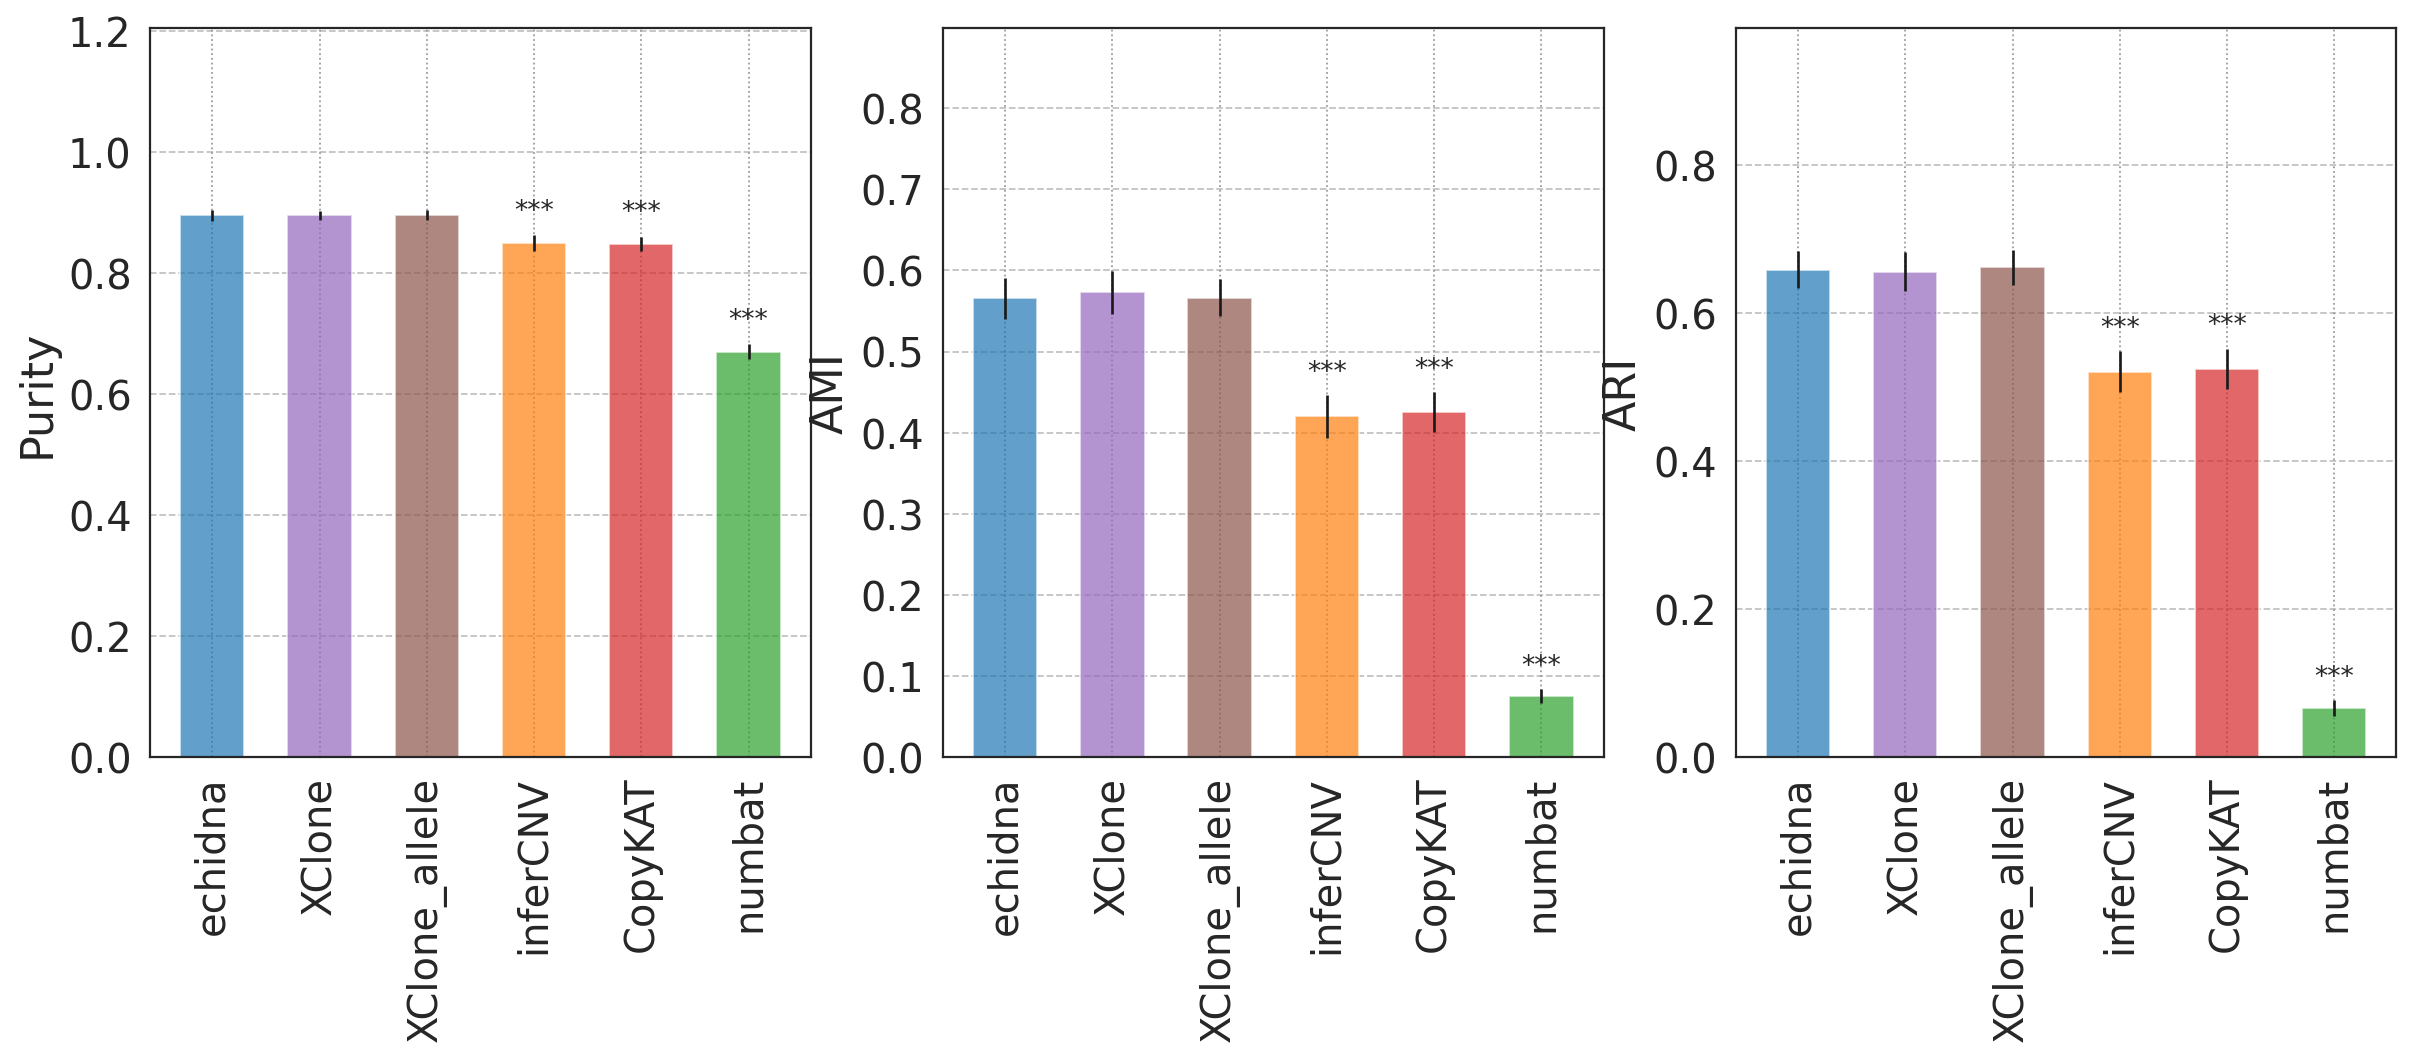

In [69]:
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_metric_bar(axes[0], 'Purity', metrics_adata1, [''], orientation='vertical')
plot_metric_bar(axes[1], 'AMI', metrics_adata1, [''], orientation='vertical')
plot_metric_bar(axes[2], 'ARI', metrics_adata1, [''], orientation='vertical')
plt.savefig("tumor5_clone_call_metrics.svg", format='svg', bbox_inches='tight', dpi=300)

In [ ]:
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/xclone_binned_tumor5.npy", xclone_binned)
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/copykat_binned_tumor5.npy", copykat_binned)

In [ ]:
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_copykat_tumor5.npy", DNA_cluster_copykat)
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_xclone_tumor5.npy", DNA_cluster_xclone)

In [ ]:
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/xclone_binned_tumor5.npy", xclone_binned)
# np.save("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_xclone_tumor2.npy", DNA_cluster_xclone)

In [ ]:
sc.write("/home/mingxuanzhang/echidna/benchmarking_data/tumor5_echidna.h5ad", tumor2)